/home/akel/anaconda2025/envs/data_ambiental2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


=== Métricas de Treino (RandomForest) ===
R²: 0.8544
MAE: 0.8570
RMSE: 1.2215

=== Importância das Variáveis ===
    Feature  Importance
0       CRA    0.271505
1  area_km2    0.233943
2   Mor/Hab    0.125749
3      T.A.    0.101651
4       IDH    0.083627
5       Mor    0.052999
6       Hab    0.046757
7     N_ren    0.041356
8   ren_avg    0.027122
9   ren_mdn    0.015291

Top-5 observados:
     Bairro  Quantidade de Depósitos Irregulares
     Tapanã                                 15.0
    Jurunas                                  9.0
   Paracuri                                  7.0
Castanheira                                  5.0
  Marambaia                                  5.0

Top-5 estimados (DIEs):
       Bairro  Depósitos Irregulares est.
       Tapanã                        15.0
 Curió-Utinga                        10.0
  Baía do Sol                         9.0
      Jurunas                         9.0
Sucurijuquara                         9.0

=== Estatística descritiva de DI

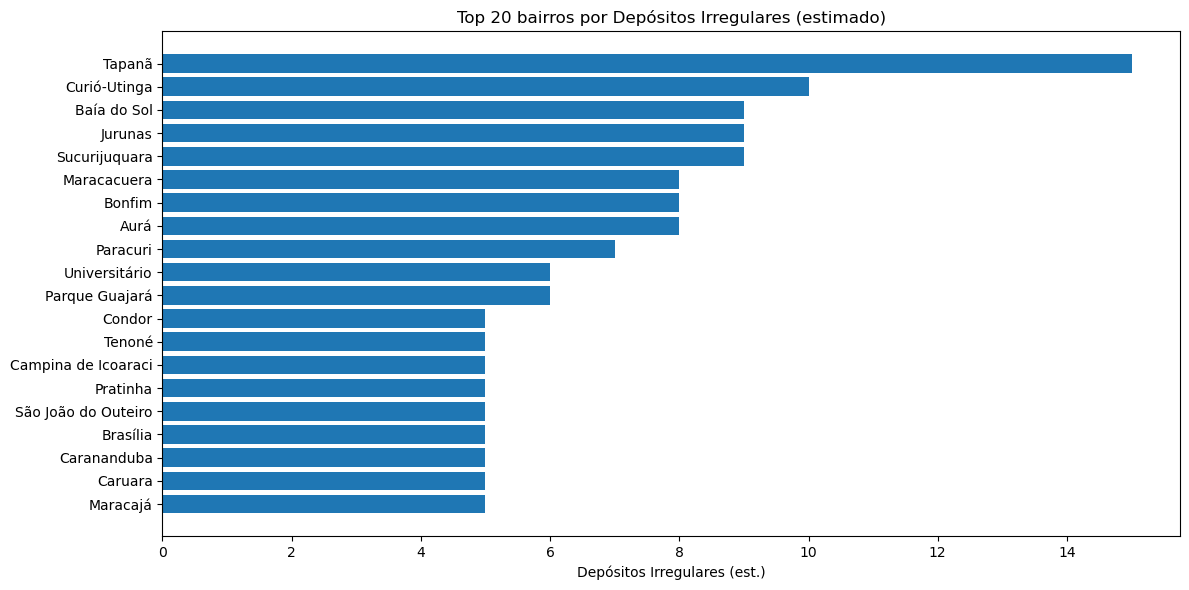

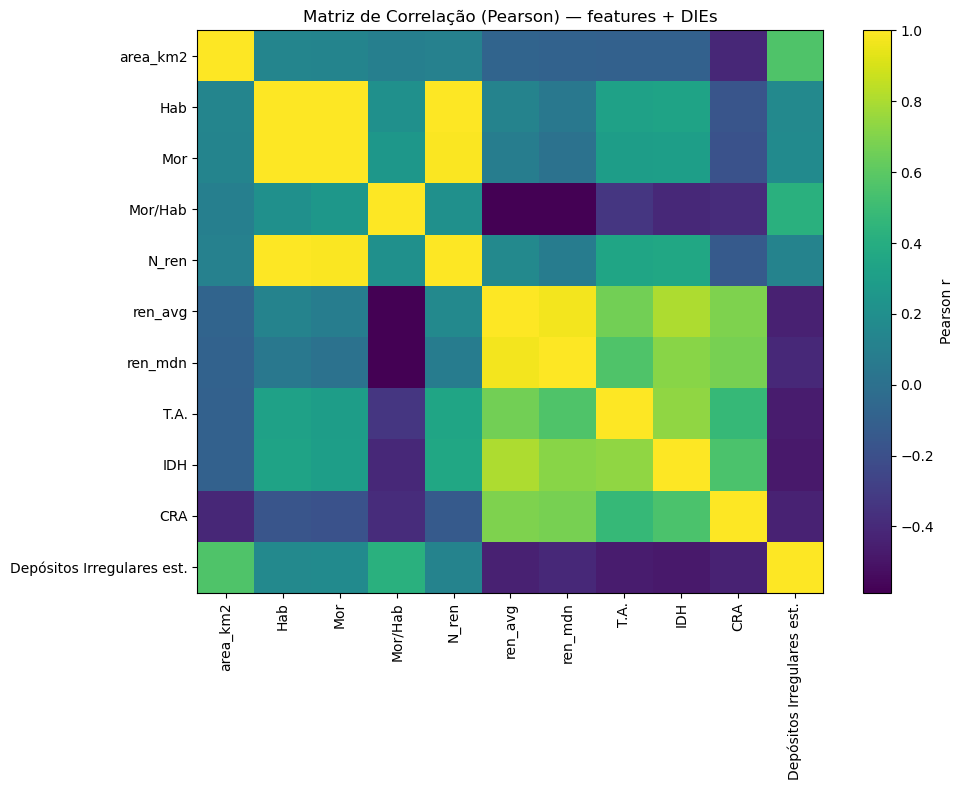

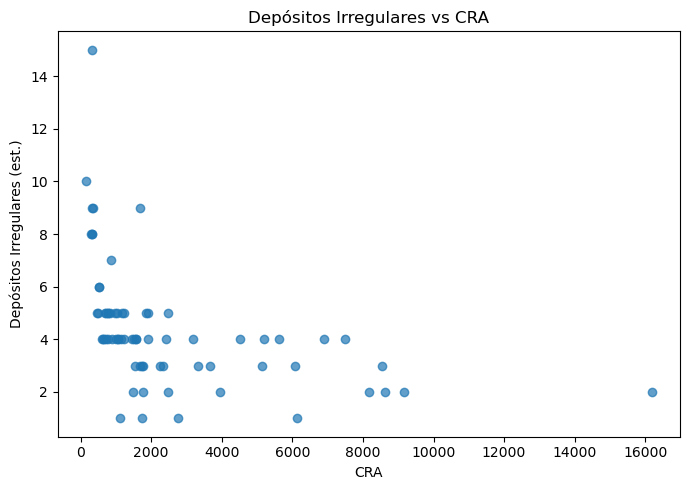

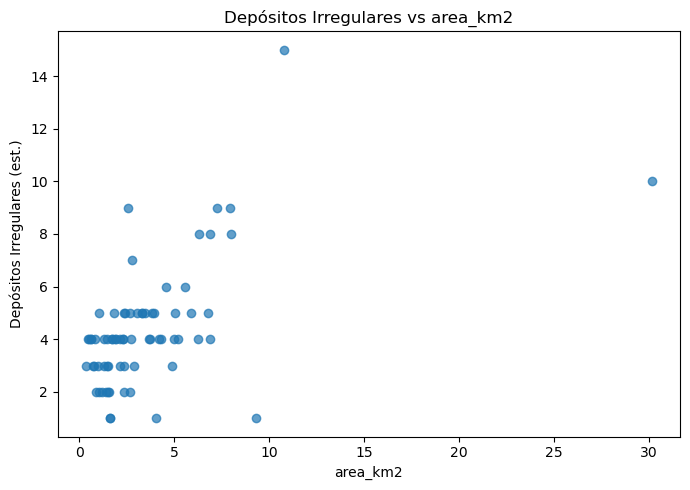

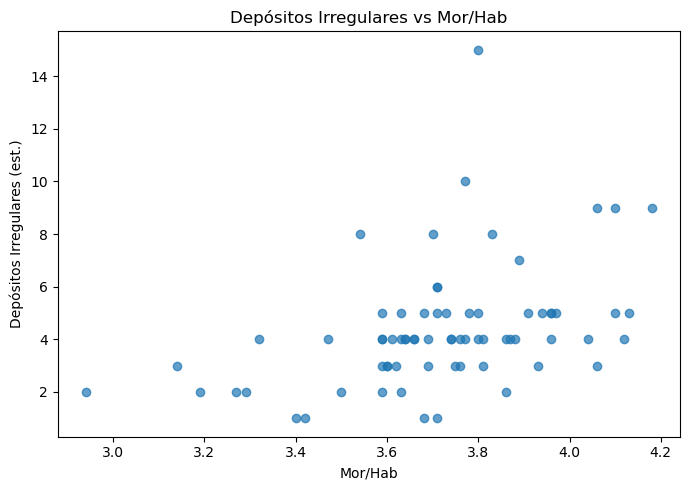


Pearson (DIEs vs CRA): r=-0.437, p=0.000138
Spearman (DIEs vs CRA): rho=-0.708, p=5.1e-12

Arquivo salvo: tabela_total_com_DIEs.csv


In [1]:
# Código para rodar localmente no seu ambiente (Python 3.9+, pandas, scikit-learn, matplotlib, seaborn opcional)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.ticker as ticker
import scipy.stats as stats

# ---------------------------
# 0) carregue os arquivos (ajuste paths)
# ---------------------------
path_proc = "/home/akel/PycharmProjects/Data_ambiental/data/process/"
df1 = pd.read_csv(path_proc + "tabela_total_final.csv")
path_raw = "/home/akel/PycharmProjects/Data_ambiental/data/raw/"
df2 = pd.read_csv(path_raw + "depositos_iregulares.Bairros.csv")

# merge (como você já faz)
df = df1.merge(df2, on="Bairro", how="left")

# renomeações/amostra: garanta colunas corretas
# df.rename(columns={...}, inplace=True) if necessário

# ---------------------------
# 1) Feature engineering
# ---------------------------
df['CRA'] = df['Mor/Hab'] * df['ren_avg'] / df['area_km2']
df['PPR'] = df['N_ren'] / df['Mor']  # se quiser repetir

# target & features
target = "Quantidade de Depósitos Irregulares"
features = ["area_km2","Hab","Mor","Mor/Hab","N_ren","ren_avg","ren_mdn","T.A.","IDH",'CRA']

# ---------------------------
# 2) Separar validas e missing
# ---------------------------
df_validas = df.dropna(subset=[target]).copy()
df_missing = df[df[target].isna()].copy()

X_train = df_validas[features]
y_train = df_validas[target]
X_predict = df_missing[features]

# ---------------------------
# 3) Treinar RandomForest e prever
# ---------------------------
model_RF = RandomForestRegressor(n_estimators=500, random_state=42)
model_RF.fit(X_train, y_train)

# previsões (treino e missing)
y_pred_train = model_RF.predict(X_train)
y_pred_missing = model_RF.predict(X_predict)

# atribuir previsões ao df_missing (arredonde se preferir)
df_missing['Depósitos Irregulares est.'] = np.round(y_pred_missing).astype(int)
df_validas['Depósitos Irregulares est.'] = df_validas[target]  # manter os valores observados

# recombinar
df_all = pd.concat([df_validas, df_missing], axis=0, ignore_index=True)

# ---------------------------
# 4) Métricas (treino)
# ---------------------------
r2 = r2_score(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print("=== Métricas de Treino (RandomForest) ===")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# importância das variáveis
importances = pd.DataFrame({
    "Feature": features,
    "Importance": model_RF.feature_importances_
}).sort_values("Importance", ascending=False).reset_index(drop=True)
print("\n=== Importância das Variáveis ===")
print(importances)

# ---------------------------
# 5) Ranking TOP-5
# ---------------------------
# Top-5 observados (com valores reais)
top5_observados = df_validas.sort_values(by=target, ascending=False).head(5)[["Bairro", target]]

# Top-5 estimados (usar coluna Depósitos Irregulares est.)
top5_estimados = df_all.sort_values(by="Depósitos Irregulares est.", ascending=False).head(5)[["Bairro", "Depósitos Irregulares est."]]

print("\nTop-5 observados:")
print(top5_observados.to_string(index=False))
print("\nTop-5 estimados (DIEs):")
print(top5_estimados.to_string(index=False))

# ---------------------------
# 6) Estatística descritiva
# ---------------------------
desc = df_all["Depósitos Irregulares est."].describe()
print("\n=== Estatística descritiva de DIEs ===")
print(desc)

# ---------------------------
# 7) Correlação entre variáveis (Pearson e Spearman)
# ---------------------------
corr_pearson = df_all[features + ["Depósitos Irregulares est."]].corr(method='pearson')
corr_spearman = df_all[features + ["Depósitos Irregulares est."]].corr(method='spearman')

# ---------------------------
# 8) Plotagens (matplotlib)
# ---------------------------
plt.figure(figsize=(12,6))
# barra dos top 20 bairros por DIEs
top20 = df_all.sort_values(by="Depósitos Irregulares est.", ascending=False).head(20)
plt.barh(top20["Bairro"][::-1], top20["Depósitos Irregulares est."][::-1])
plt.xlabel("Depósitos Irregulares (est.)")
plt.title("Top 20 bairros por Depósitos Irregulares (estimado)")
plt.tight_layout()
plt.show()

# Heatmap correlação (usando matplotlib puro)
plt.figure(figsize=(10,8))
m = corr_pearson.values
plt.imshow(m, interpolation='none', aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr_pearson.columns)), corr_pearson.columns, rotation=90)
plt.yticks(range(len(corr_pearson.columns)), corr_pearson.columns)
plt.title("Matriz de Correlação (Pearson) — features + DIEs")
plt.tight_layout()
plt.show()

# Scatter plots das top 3 features vs DIEs
top_feats = importances["Feature"].head(3).tolist()
for f in top_feats:
    plt.figure(figsize=(7,5))
    plt.scatter(df_all[f], df_all["Depósitos Irregulares est."], alpha=0.7)
    plt.xlabel(f)
    plt.ylabel("Depósitos Irregulares (est.)")
    plt.title(f"Depósitos Irregulares vs {f}")
    # ajuste da escala se necessário
    plt.tight_layout()
    plt.show()

# ---------------------------
# 9) Testes estatísticos simples
# ---------------------------
# Pearson e Spearman entre DIEs e CRA
pearson_cr = stats.pearsonr(df_all['CRA'].fillna(0), df_all['Depósitos Irregulares est.'])
spearman_cr = stats.spearmanr(df_all['CRA'].fillna(0), df_all['Depósitos Irregulares est.'])
print("\nPearson (DIEs vs CRA): r={:.3f}, p={:.3g}".format(pearson_cr[0], pearson_cr[1]))
print("Spearman (DIEs vs CRA): rho={:.3f}, p={:.3g}".format(spearman_cr.correlation if hasattr(spearman_cr,'correlation') else spearman_cr[0], spearman_cr.pvalue if hasattr(spearman_cr,'pvalue') else spearman_cr[1]))

# Salvar resultados resumidos (opcional)
#df_all.to_csv(path_proc + "tabela_total_com_DIEs.csv", index=False)
print("\nArquivo salvo: tabela_total_com_DIEs.csv")


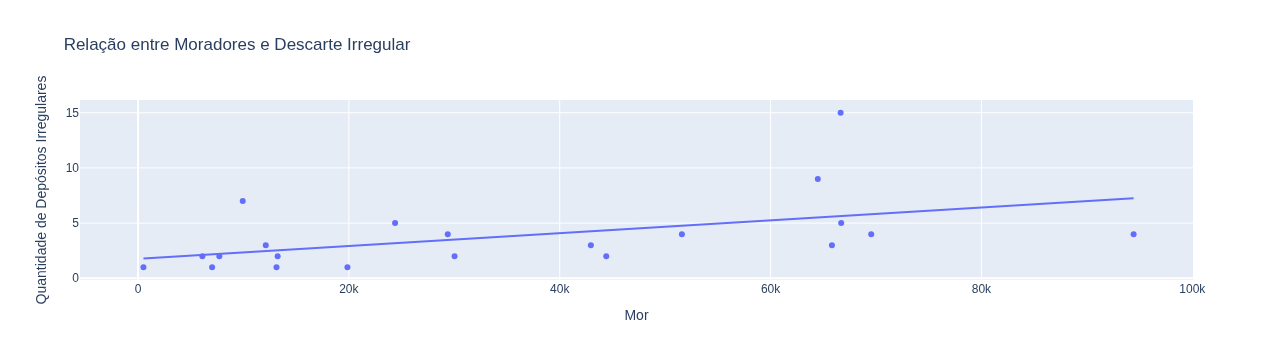

In [2]:
import plotly.express as px

fig = px.scatter(
    df,
    x="Mor",
    y="Quantidade de Depósitos Irregulares",
    hover_name="Bairro",
    trendline="ols",
    title="Relação entre Moradores e Descarte Irregular"
)
fig.show()




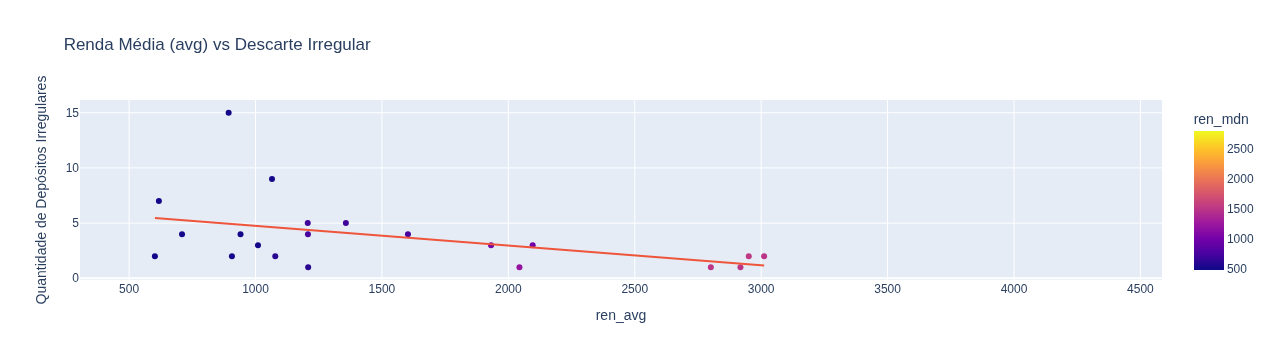

In [3]:
fig = px.scatter(
    df,
    x="ren_avg",
    y="Quantidade de Depósitos Irregulares",
    color="ren_mdn",
    hover_name="Bairro",
    trendline="ols",
    title="Renda Média (avg) vs Descarte Irregular",
    labels={"avg": "Renda Média", "mdn": "Mediana da Renda"}
)
fig.show()

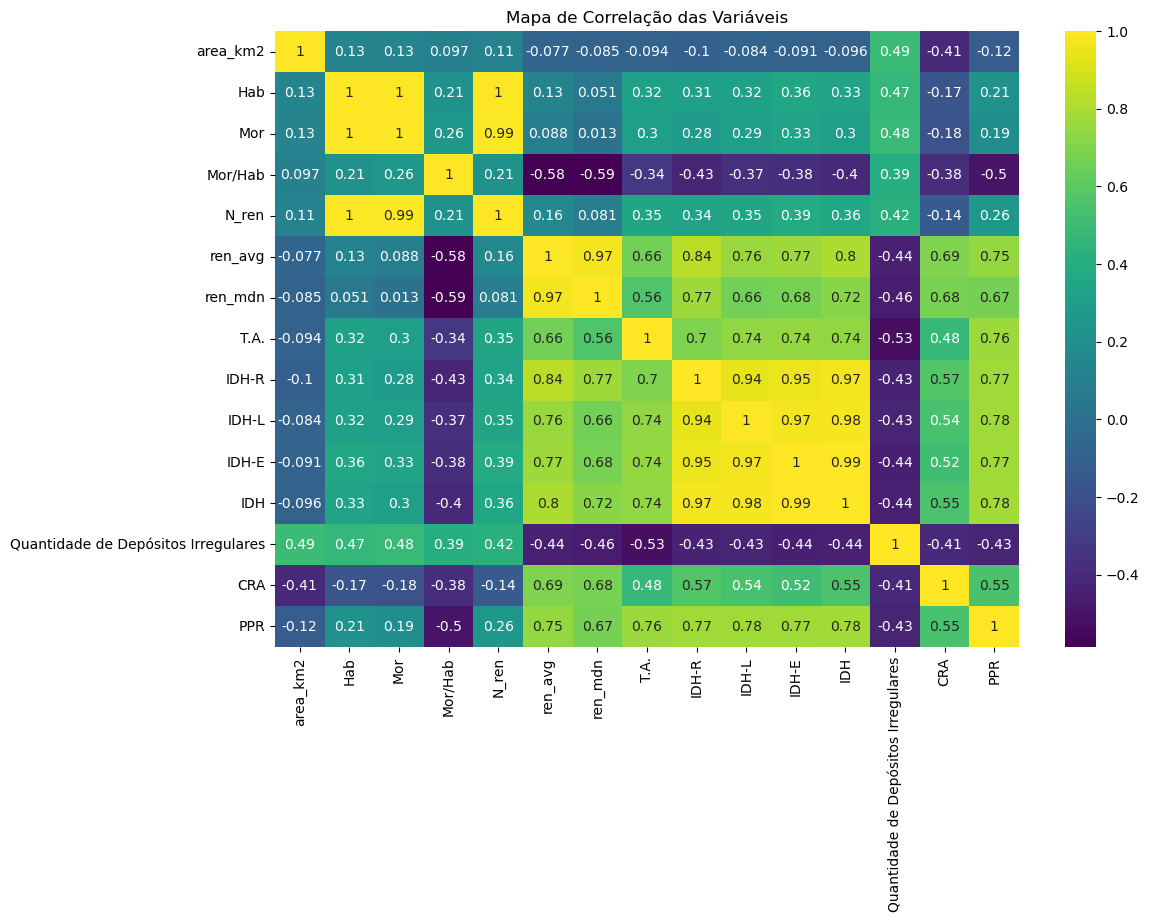

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="viridis")
plt.title("Mapa de Correlação das Variáveis")
plt.show()

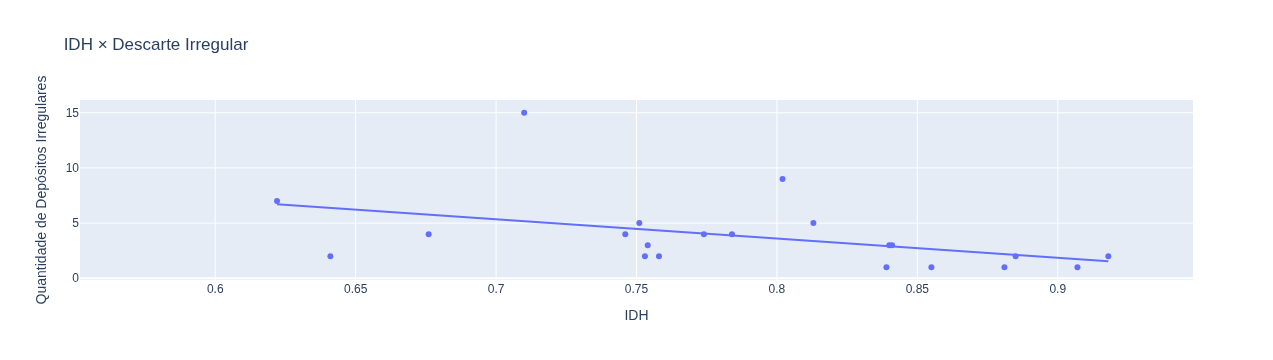

In [5]:
fig = px.scatter(
    df,
    x="IDH",
    y="Quantidade de Depósitos Irregulares",
    hover_name="Bairro",
    trendline="ols",
    title="IDH × Descarte Irregular"
)
fig.show()


In [6]:
fig = px.box(
    df,
    y="Quantidade de Depósitos Irregulares",
    x="Bairro",
    title="Distribuição de Descartes por Bairro",
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [7]:
df['quartil_renda'] = pd.qcut(df['ren_avg'], 4, labels=["Baixa", "Média-Baixa", "Média-Alta", "Alta"])

fig = px.box(
    df,
    x="quartil_renda",
    y="Quantidade de Depósitos Irregulares",
    title="Descarte Irregular por Faixas de Renda"
)
fig.show()